# Pneumonia Detection with ResNet50

This notebook fine‑tunes **ResNet50** on chest X‑ray images to classify **Pneumonia** vs **Normal**.



## Setup

In [1]:
# !pip install -q -U tensorflow tensorflow-addons scikit-learn seaborn matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

print("TensorFlow:", tf.__version__)

/Users/atulaneja/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow: 2.19.0


## Data Preprocessing

In [2]:
DATA_DIR = Path('chest_xray')  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'train',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'val',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'test',
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Data augmentation & preprocessing
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

def preprocess(x, y):
    x = keras.applications.resnet.preprocess_input(x)
    return x, y

train_ds = train_ds.map(preprocess).map(lambda x, y: (data_augmentation(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## Build Model

In [3]:
base_model = keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train

In [4]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 375ms/step - accuracy: 0.7413 - loss: 0.5194 - val_accuracy: 0.5625 - val_loss: 0.7100
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - accuracy: 0.8650 - loss: 0.3201 - val_accuracy: 0.6250 - val_loss: 0.6662
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 386ms/step - accuracy: 0.9000 - loss: 0.2498 - val_accuracy: 0.6250 - val_loss: 0.6599
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.9098 - loss: 0.2218 - val_accuracy: 0.6250 - val_loss: 0.6928
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9208 - loss: 0.2052 - val_accuracy: 0.6250 - val_loss: 0.6831
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 382ms/step - accuracy: 0.9281 - loss: 0.1825 - val_accuracy: 0.6250 - val_loss: 0.7045
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 384ms/step - accuracy: 0.9386 - loss: 0.1682 - val_accuracy: 0.6250 - val_loss: 0.7252
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 386ms/step - accuracy: 0.9372 - loss: 0

### Fine‑tuning

In [5]:
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
FINE_EPOCHS = 5
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=EPOCHS,
    epochs=EPOCHS + FINE_EPOCHS,
)

Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9005 - loss: 0.2659 - val_accuracy: 0.6875 - val_loss: 0.5544
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9608 - loss: 0.1004 - val_accuracy: 1.0000 - val_loss: 0.1425
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9756 - loss: 0.0703 - val_accuracy: 1.0000 - val_loss: 0.0977
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9797 - loss: 0.0607 - val_accuracy: 1.0000 - val_loss: 0.0775
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9816 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 0.0369


## Plot Training History

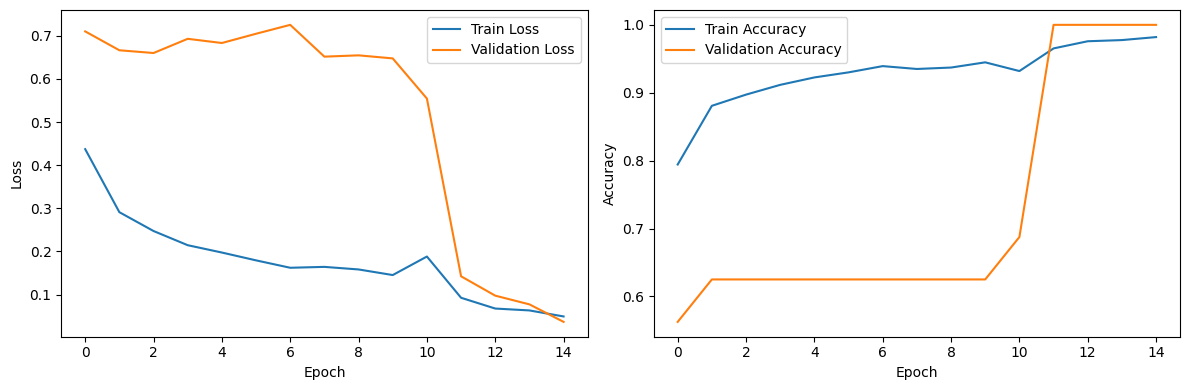

Saved training_history.png


In [9]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist_ft = pd.DataFrame(history_ft.history)
combined = pd.concat([hist, hist_ft.tail(FINE_EPOCHS)], ignore_index=True)

train_losses = combined['loss']
val_losses   = combined['val_loss']
train_accs   = combined['accuracy']
val_accs     = combined['val_accuracy']

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('training_history.png')
plt.close()
print('Saved training_history.png')

## Evaluate & Visualize

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8262 - loss: 0.4590
Test Accuracy: 88.46%


2025-06-19 13:26:39.864094: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.73      0.83       234
   PNEUMONIA       0.86      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



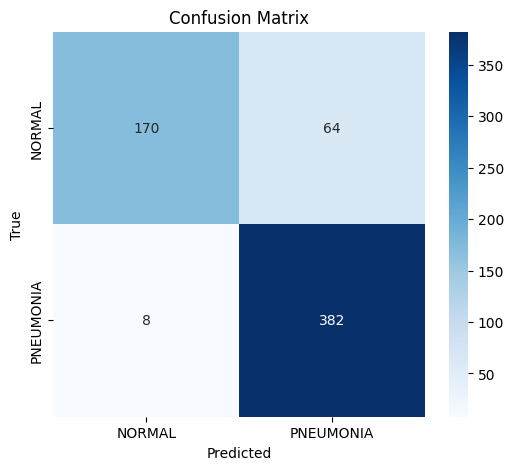

Saved confusion_matrix.png


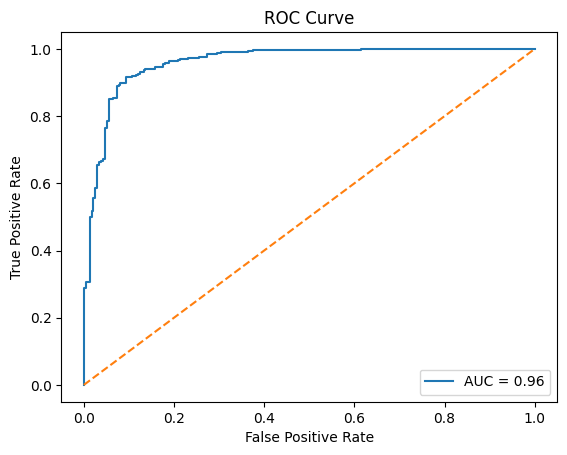

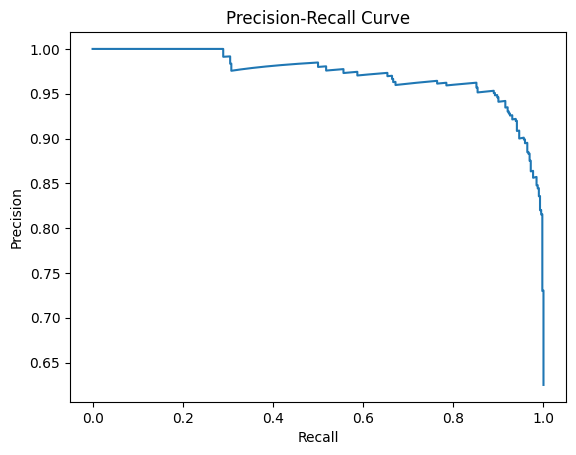

Saved roc_curve.png and precision_recall_curve.png


In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()
print('Saved confusion_matrix.png')

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
plt.savefig('roc_curve.png')
plt.close()

# PR curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
plt.savefig('precision_recall_curve.png')
plt.close()

print('Saved roc_curve.png and precision_recall_curve.png')

## Prediction Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


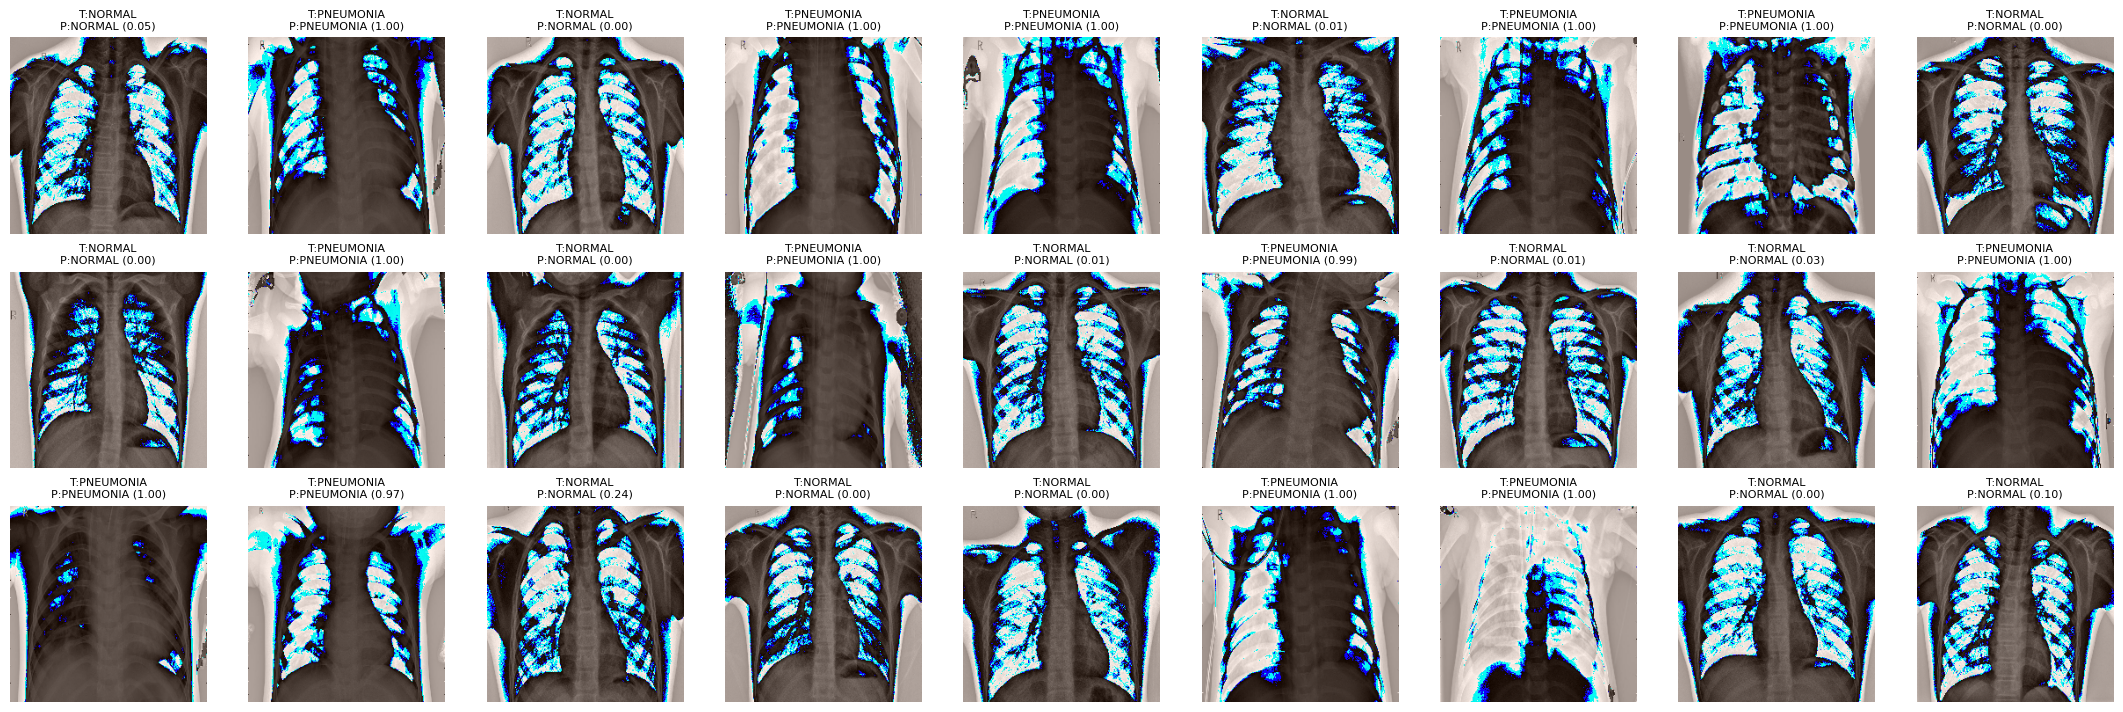

Saved prediction_examples.png


In [ ]:
def visualize_predictions(dataset, total_images=27):
    import matplotlib.pyplot as plt, random, tensorflow as tf, numpy as np

    n_classes = len(class_names)           
    samples_per_class = total_images // n_classes   
    extras = total_images % n_classes                

    # Collect images from each class
    bank = {i: [] for i in range(n_classes)}         

    for img, lbl in dataset.unbatch():
        idx = int(lbl.numpy())
        target = samples_per_class + (1 if extras > 0 and idx == 0 else 0)
        if len(bank[idx]) < target:
            bank[idx].append(img)
        # Stop when every class bucket reached its target
        if all(len(v) >= (samples_per_class + (1 if extras > 0 and k == 0 else 0))
               for k, v in bank.items()):
            break

    # Flatten and shuffle the images
    images, true_labels = [], []
    for k, imgs in bank.items():
        images.extend(imgs)
        true_labels.extend([k] * len(imgs))
    combined = list(zip(images, true_labels))
    random.shuffle(combined)

    stacked = tf.stack([c[0] for c in combined])
    probs   = model.predict(stacked).ravel()
    preds   = (probs > 0.5).astype(int)

    n_rows, n_cols = 3, 9                  # 3 × 9 grid
    plt.figure(figsize=(2.4 * n_cols, 2.4 * n_rows))

    for i, (img, t_idx) in enumerate(combined):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(
            f"T:{class_names[t_idx]}\n"
            f"P:{class_names[preds[i]]} ({probs[i]:.2f})",
            fontsize=8,
        )

    plt.tight_layout()
    plt.savefig("prediction_examples.png", dpi=200)   # keep file
    plt.show()
    print("Saved prediction_examples.png")

visualize_predictions(test_ds)
